# N-Body Simulation

An attempt to simulate the N-Body Problem with a reasonable amount of Bodies (Planets). For simplicity, different types such as gas, dark matter etc. are not considered.


In this ipynb, the simulation is shown via matplotlib. The final animation is planned to be visualized by:
* [GlNemo2](https://projets.lam.fr/projects/glnemo2) (on [gitlab.lam.fr](https://gitlab.lam.fr/jclamber/glnemo2)) - A 3D visualization program
* [python-unsio](https://pypi.org/project/python-unsio/) ([projects.lam.fr](https://projets.lam.fr/projects/unsio)) - A python library to generate NBody Snapshots

In [1]:
%matplotlib notebook

# Allows auto-reloading all imports
%load_ext autoreload

In [2]:
%autoreload  # Auto-reload all imports

from collections import namedtuple
from matplotlib import pyplot as plt
from tqdm import tqdm
from random import random
import multiprocessing as mp
import numpy as np
import scipy.constants

## Parameters
Contains widely used constants for the Simulation, such as `G`, the Gravitational constant or the `TIME_INTERVAL`, used to define the timestep / calculation.

In [3]:
G = scipy.constants.G
TIME_INTERVAL = 5

## Bodies
A body is defined by its name, mass, (initial) position and (initial) velocity. A body is **only** described by its initial position and velocity. The Bodies can be generated randomly or with manual values.

## Numpy Coordinates
To perform the calculations, a `numpy.array` is generated with initial positions and velocities. This array is updated every timestep and should be used for any calculations.
It is a Numpy Float64 array with 3 axes (dimensions):
* List of Bodies
* List of [Position, Velocity]
* List of Coordinates (3DVector, 3*float64)

In [4]:
Body = namedtuple('Body', 'name, mass, position, velocity')


def get_random_bodies(n=2):
    '''
    Generates `n` bodies randomly, with a random mass, position and 0 velocity.
    '''
    def rd_vector(mu): return np.random.normal(mu, 0.2, (3,))

    for i in range(n):
        yield Body(name=f'P{i}', mass=100 * random(), position=rd_vector(0.5), velocity=np.zeros((3,)))

In [5]:
def create_arr_from_bodies(bodies, arr=None):
    if arr is not None:
        for ib, b in enumerate(bodies):
            arr[ib] = b.position, b.velocity
    return np.array(tuple((b.position, b.velocity) for b in bodies))

# Function to quickly generate random Position and Velocity Vectors for testing
# def create_random(amount): return np.random.normal(0.5, 0.3, (amount, 2, 3))

# Scaling Functions
* Mass Scalling

In [6]:
def mass_units_scallng(bodies):
    """
    Takes list of all N bodies as argument and returns list with bodies having
    scaled masses
    By convention, all masses add up to 1, therefore the mean mass is always 1/N
    """
    # TODO

# Computing Functions
* Total Energy of System
    $ E = \frac{1}{2}\sum\limits _{i=1} ^{N}m_{j}v_{i}^2 - \sum\limits _{i=1} ^{N}\sum\limits _{j > 1} ^{N}\frac{Gm_{i}m_{j}}{|r_{i} - r_{j}|^3}$

* Total Kinetic Energy
    $ E_{c} = \frac{1}{2}\sum\limits _{i=1} ^{N}m_{i}v_{i}^2 $
   
* Total Potential Energy
    $ E_{p} = -\sum\limits _{i=1} ^{N}\sum\limits _{j>i}{N}\frac{Gm_{i}m_{j}}{|r_{i} - r_{j}|^3}$
    
* Lagrangian energy
    L = T - U
    
    
* Crossing Time
    For approximate dynamical equilibrium
    $ t_{cr} = \frac{2R_{v}}{\sigma} $
    $ R_{v} = \frac{GN^2\bar{m}}{2|U|} $
    $ \sigma^2 = \frac{GN\bar{m}}{2R_{v}} $
    $ \bar{m} = \frac{1}{N} $
    

In [7]:
def get_total_energy(arr):
    """
    Takes list of all bodies as argument and returns total energy of the entire N-Body system
    
    """
    1 / 2 * np.sum()
    
    

In [8]:
def get_total_kinetic_energy(bodies):
    """
    Takes list of all bodies as argument and returns the total amount of kinetic energy of the N body system
    For simplicity reasons, only classical mechanics are applied for this project
    Total kinetic energy represented by "T", T >= 0
    """
    #TODO

In [9]:
def get_total_potential_energy(bodies):
    """
    Takes list of all bodies as argument and returns the total potential energy of the N-Body System
    By convention, potential energy is represented by "U" and U <= 0
    """

In [10]:
def get_total_lagrangian_energy(bodies):
    return get_total_kinetic_energy(bodies) - get_total_potential_energy(bodies)

In [11]:
def total_croissing_time(bodies):
    """
    Takes list of all bodies as argument and returns the crossing time of the N-Body System
    The crossing time is defined as the time needed to travers the system's galaxy
    once entirely
    Note that this simulation will therefore not be used to describe the movement of a whole galaxy
    
    """
    

# Utility Functions
* Pretty printing coordinates
* Scale Mass units

In [12]:
def pretty_print_coordinates(bodies, arr):
    """
    Pretty Printing Coordinates (Format: `BodyName - (x; y; z)` with 4 decimals)
    """
    for body, x in zip(bodies, arr):
        p = x[0]
        coordinates = '; '.join(f'{p[i]:.4f}' for i in range(3))
        print(f'{body.name} - ({coordinates})')

# Update Function

This is the core of the simulation: the functions that update velocities and positions of all `bodies` for an interval `timestep`.

## Simple Newton
Implementation of Equations derived from "*Newton's laws of motion*" and "*Newton's law of universal gravitation*"


1. Calculate norm of the vector a:
    * Newton's law of motion: $ \vec{F} = m\vec{a}$
    * Newton's law of universal gravitation: $ F = G \times \frac{m_1 \times m_2}{r^2}$


2. Direction of the vector a: normalized vector $ \hat r = \frac{\vec r}{\lVert \vec r \rVert}$

Putting both equations together:
$$ m_1 \times \vec a = G \times \frac{m_1 \times m_2}{\lVert \vec r \rVert ^2} \times \hat r $$

and finally:
$$ \Rightarrow \vec a = G \times \frac{m_2}{\lVert \vec r \rVert ^3} \times \vec r $$


This implementation computes the $ \sum \limits_{k=1}^n \vec{a_k} $ (sum of all forces applied on the current body exerted by every body) for each body and calculates velocity and positions with a very simplistic approach.

In [13]:
def simple_newton(arr, bodies, timestep=TIME_INTERVAL):
    """
    :param arr: Array of positions and velocities that will be used and updated during calculation
    :param bodies: Iterable of bodies (same length as `arr` that will be used to retrieve mass)
    :param timestemp: The timestep used for one calculation step.
    """
    for idx1, b1 in enumerate(arr):
        acceleration = np.zeros((3,))
        for idx2, b2 in enumerate(arr):

            if idx1 == idx2:
                continue

            d_vec = np.subtract(b2[0], b1[0])
            normalized = d_vec / np.linalg.norm(d_vec)

            r_2 = np.sum(np.power(d_vec, 2))
            m2 = bodies[idx2].mass

            a = G * m2 / r_2
            acceleration += (a * normalized)
        arr[idx1, 1] += acceleration * timestep
    for idx, b in enumerate(arr):
        arr[idx, 0] += b[1] * timestep

# Start of the simulation

Defining Bodies and function to be used, generating array of Positions and starting the matplotlib simulation.

In [14]:
bodies = tuple(get_random_bodies(4))
"""
# Experimenting with hardcoded Values for Bodies
bodies = (
    Body("Sun", 10e10, (0, 0, 0), )
)
"""

'\n# Experimenting with hardcoded Values for Bodies\nbodies = (\n    Body("Sun", 10e10, (0, 0, 0), )\n)\n'

In [15]:
# Define function to be used
calc_next_step = simple_newton

In [16]:
# Reset / generate initial position and velocities
arr = create_arr_from_bodies(bodies)
pretty_print_coordinates(bodies, arr)

P0 - (0.5658; 0.6597; 0.8278)
P1 - (0.6086; 0.3636; 0.4368)
P2 - (0.7006; 0.2163; 0.2985)
P3 - (0.6105; 0.5817; 0.4078)


<IPython.core.display.Javascript object>


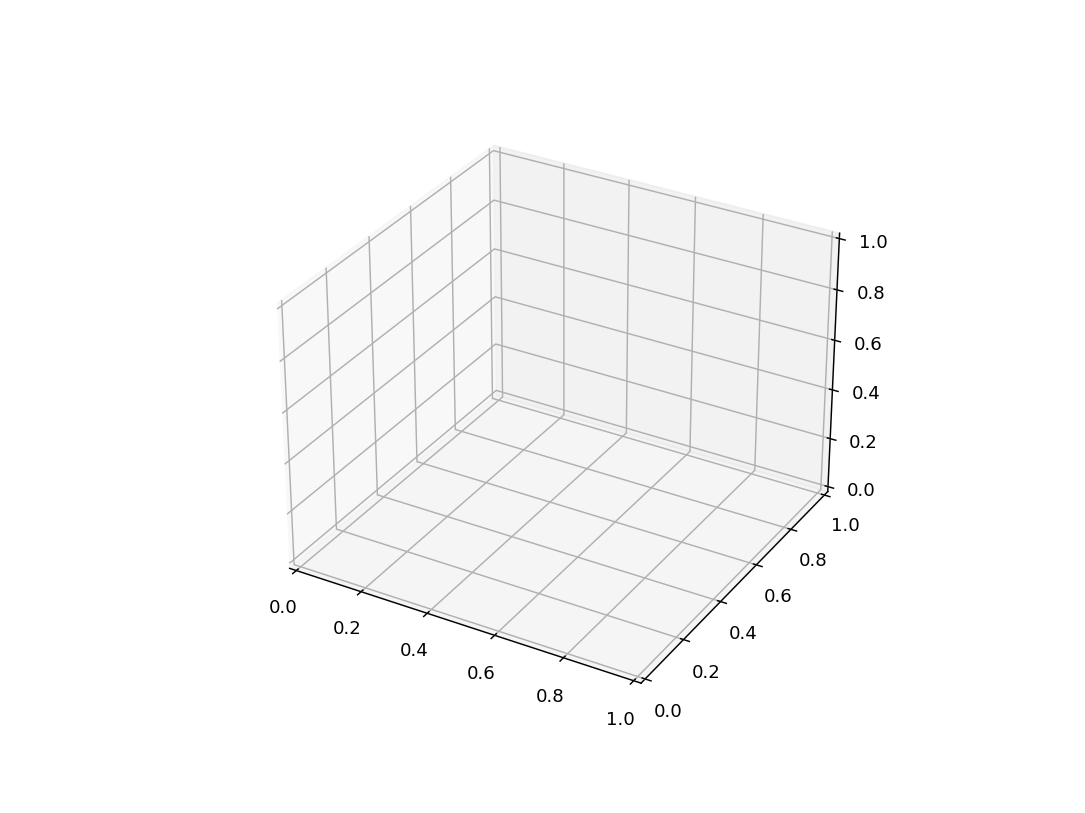



Received SIGINT. Closing simulation

Last Values:
P0 - (0.5667; 0.6582; 0.8196)
P1 - (0.6084; 0.3998; 0.4375)
P2 - (0.6976; 0.2277; 0.3039)
P3 - (0.6097; 0.5826; 0.4161)


In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

try:
    while True:
        calc_next_step(arr, bodies)
        ax.cla()
        
        # Without Loop
#         positions = arr[:, [0]].reshape(-1, 3)
#         xs, ys, zs = positions[:, [0]], positions[:, [1]], positions[:, [2]]
#         ax.scatter(xs, ys, zs, s=tuple(map(lambda b: b.mass, bodies)))

        # With Loop
        for idx, (xs, ys, zs) in enumerate(map(lambda x: x[0], arr[:, [0]])):
            ax.scatter(xs, ys, zs, marker='o', s=bodies[idx].mass)
        fig.canvas.draw()
        fig.show()
except KeyboardInterrupt as e:
    print(); print()
    print("Received SIGINT. Closing simulation")
    print()
    print("Last Values:")
    pretty_print_coordinates(bodies, arr)

<IPython.core.display.Javascript object>


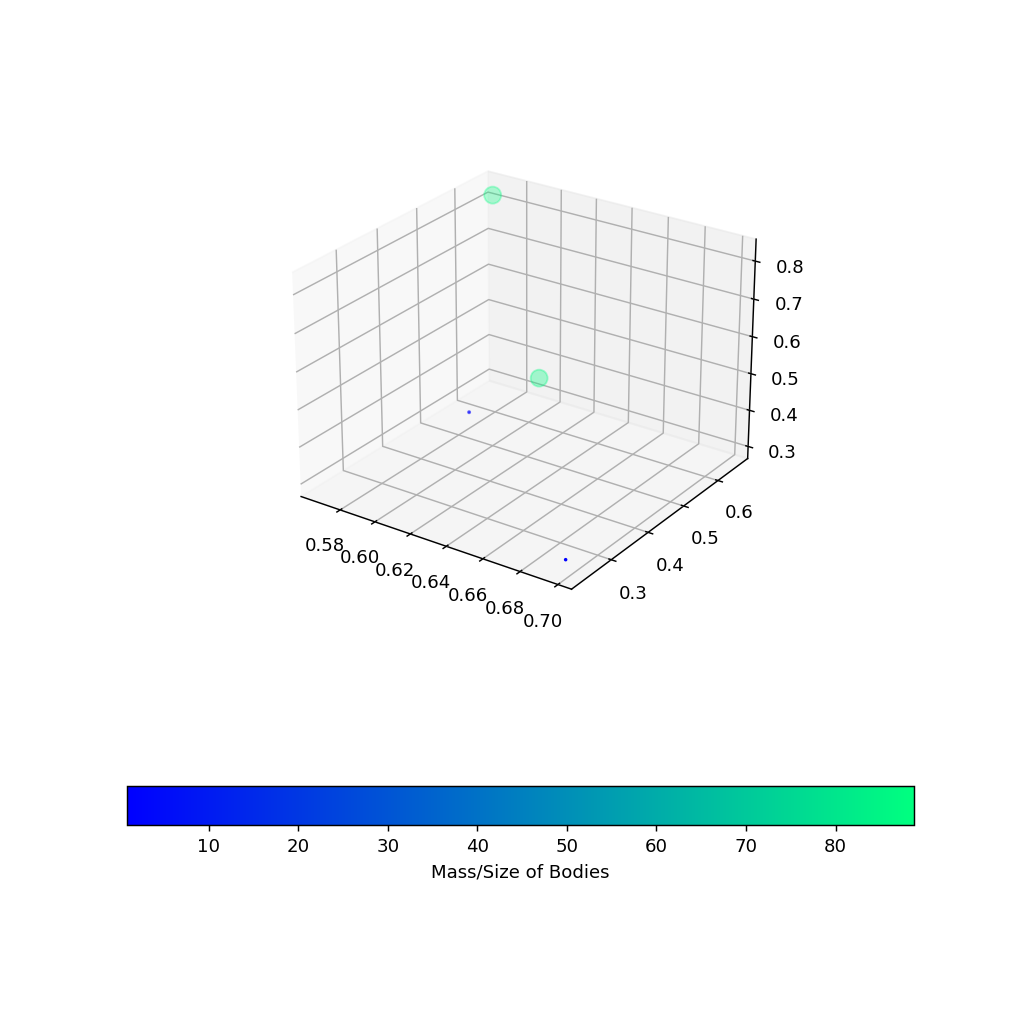

In [18]:
def show_final_with_mass():
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    positions = arr[:, [0]].reshape(-1, 3)
    xs, ys, zs = positions[:, [0]], positions[:, [1]], positions[:, [2]]
    size = tuple(map(lambda b: b.mass, bodies))
    
    r = ax.scatter(xs, ys, zs, s=size, c=size, cmap='winter')
    fig.colorbar(r, pad=0.2, orientation='horizontal', label="Mass/Size of Bodies")


show_final_with_mass()

# Using Shared Memory for true parallelization

In [40]:
def newton_parallelized(arr, ifrom, ito, bodies, timestep=TIME_INTERVAL):
    for i1 in range(ifrom, ito):
        b1_pos = arr[i1][0]
        acceleration = np.zeros((3,))
        for i2, b2_pos in enumerate(map(lambda x: x[0], arr)):
            
            if i1 == i2:
                continue
            
            d_vec = np.subtract(b2_pos, b1_pos)
            normalized = d_vec / np.linalg.norm(d_vec)
            
            r_2 = np.sum(np.power(d_vec, 2))
            m2 = bodies[i2].mass
            
            a = G * m2 / r_2
            acceleration += (a * normalized)
        arr[i1, 1] += acceleration * timestep


def compute_multi_process(steps, arr, bodies):
    threads = mp.cpu_count()

    total = len(bodies)

    chunked = total // threads
    bonus = total - chunked * threads

    print('There are', threads, 'Threads available')
    print('Processing', chunked, 'chunks per thread, requires', bonus, 'extra steps. ')

    with mp.Pool(processes=threads) as pool:
        for _ in range(steps):
            awaits = []
            for x in range(threads):
                sub_total = chunked
                if x + 1== threads:
                    sub_total += bonus
                ifrom = chunked * x
                ito = ifrom + sub_total
                awaits.append(pool.apply_async(newton_parallelized, args=(arr, ifrom, ito, bodies)))
            for a in awaits:
                a.get(None)

if False:
    import SharedArray as sa


    # This allows sharing memory between multiple processes (without having to use blocking queues or other
    # IPC mechanisms. This should be the fastest way and it is all abstracted as a Numpy array.
    bodies = tuple(get_random_bodies(400))
    try:
        sa.delete('arr')
    except:
        print("No Array to delete")
    arr = sa.create("shm://arr", (len(bodies), 2, 3))
    create_arr_from_bodies(bodies, arr)
    compute_multi_process(20, arr, bodies)